In [2]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import pathlib
import json
import seaborn as sns
import matplotlib.pyplot as plt

symbols_list_file_name = "binance_BTC_from_2019_05_01_to_2022_04_30.json"
with open(symbols_list_file_name, "r") as f:
    symbols_list = json.load(f)
symbols_list.remove('scbtc')

winsorise = False 
figures_folder_name = "figures"
figures_subfolder_name = "exploration"
if winsorise:
    returns_folder_name = "full_returns_winsorised"
    figures_subsubfolder_name = "winsorised"
else:
    returns_folder_name = "full_returns"
    figures_subsubfolder_name = "raw"

figures_path_base = os.path.join(
    os.getcwd(),
    figures_folder_name,
    figures_subfolder_name,
    figures_subsubfolder_name,
)

ts_list = []
for symbol in symbols_list:
    save_file_name = symbol + '.csv.gz'
    save_path = os.path.join(os.getcwd(), returns_folder_name, save_file_name)
    df = pd.read_csv(save_path, compression='gzip')
    ts_list.append(df['log_return'].rename(symbol))
all_returns_df = pd.concat(ts_list, axis=1)

pathlib.Path(figures_path_base).mkdir(parents=True, exist_ok=True)

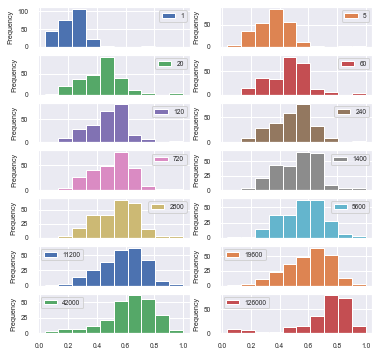

In [57]:
def compute_vol_corr_df(input_df, increments_list):
    corr_series_list = []
    squared_returns = all_returns_df.pow(2)
    for increment in increments_list:
        df = squared_returns.groupby(squared_returns.index // increment).sum().pow(1./2)
        corr_matrix = df.corr()
        upper_mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        corr_series = corr_matrix.where(upper_mask).stack()
        corr_series.rename(increment, inplace=True)
        corr_series_list.append(corr_series)
    return pd.concat(corr_series_list, axis=1)

increments_list = [1, 5, 20, 60, 120, 240, 720, 1400, 1400 * 2, 1400 * 4, 1400 * 8, 1400 * 14, 1400 * 30, 1400 * 30 * 3]
sns.set_context('paper')
# sns.set(font_scale=0.1)
sns.set(rc={'figure.figsize':(6, 6)}, font_scale=0.6) 

df = compute_vol_corr_df(all_returns_df, increments_list)

info_string_list = [f"{increment} minute(s)" for increment in increments_list]

ax = df.plot.hist(subplots=True, legend=True, layout=(7,2))
figure_name = 'pairwise_vol_corr_hist_for_different_lookbacks.png'
figure_path = os.path.join(figures_path_base, figure_name)
ax[0][0].figure.savefig(figure_path, bbox_inches='tight', dpi=300)

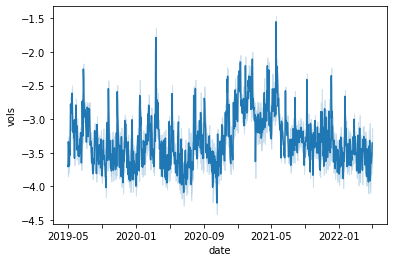

In [3]:
increment = 1440
squared_returns = all_returns_df.pow(2)
volatilities = squared_returns.groupby(
    squared_returns.index // increment).sum().pow(1./2)
volatilities = np.log(volatilities)
date = volatilities.index.to_series().apply(
    lambda x: dt.datetime(2019, 5, 1) + dt.timedelta(days=x)
)
daily_volatilities = pd.concat([volatilities, date], axis=1)
daily_volatilities.rename(columns={0: 'date'}, inplace=True)
molten = daily_volatilities.melt('date', var_name='assets', value_name='vols')
plt = sns.lineplot(data=molten, x='date', y='vols')
for i, label in enumerate(plt.xaxis.get_ticklabels()):
    if i % 2 != 0:
        label.set_visible(False)

In [11]:
figure_name = 'daily_volatility.png'
figure_path = os.path.join(figures_path_base, figure_name)
plt.figure.savefig(figure_path, bbox_inches='tight', dpi=300)

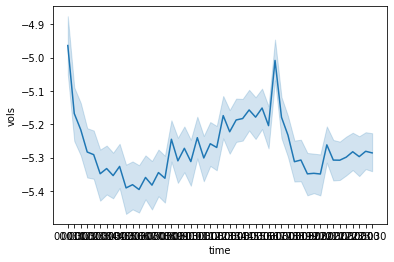

In [34]:
increment = 30
ticks = 1440 / increment
squared_returns = all_returns_df.pow(2)
volatilities = squared_returns.groupby(
    squared_returns.index // increment).sum().pow(1./2)
diurnal_volatilities = volatilities.groupby(volatilities.index % ticks).mean()
diurnal_volatilities = np.log(diurnal_volatilities)
time_of_day = (
    diurnal_volatilities.index.to_series() * increment * 60
).astype(int).apply(
    lambda x: dt.datetime.utcfromtimestamp(x).strftime('%H:%M')
)
timed_diurnal_volatilities = pd.concat(
    [diurnal_volatilities, time_of_day], axis=1
)
timed_diurnal_volatilities.rename(columns={0: 'time'}, inplace=True)
molten = timed_diurnal_volatilities.melt(
    'time', var_name='assets', value_name='vols'
)
plt = sns.lineplot(data=molten, x='time', y='vols')

In [40]:
x_axis_tick_frequency = 240
if increment < x_axis_tick_frequency:
    ticks = plt.xaxis.get_major_ticks()
    labels = plt.xaxis.get_ticklabels()
    for i, (label, tick) in enumerate(zip(labels, ticks)):
        if i % int(x_axis_tick_frequency / increment) != 0:
            label.set_visible(False)
            tick.set_visible(False)

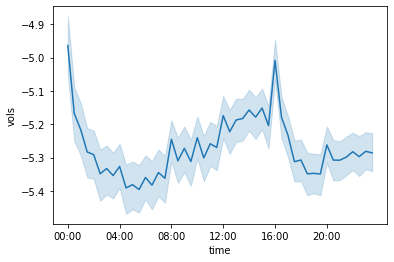

In [41]:
plt.figure

In [42]:
figure_name = 'diurnal_30m_volatility.png'
figure_path = os.path.join(figures_path_base, figure_name)
plt.figure.savefig(figure_path, bbox_inches='tight', dpi=300)